# 两种情感分析的方法尝试

In [1]:
#coding:UTF-8
import jieba
import sys
import os
from snownlp import SnowNLP
from snownlp import sentiment
input_file=r'E:\python\noval1从1983开始'
#output_file='E:/result.txt/'
def read_and_analysis(input_file):
    #f = open(r'E:\python\noval1从1983开始)         
    rootdir = r'E:\python\noval1从1983开始'
    list = os.listdir(rootdir) #列出文件夹下所有的目录与文件
    #print(list)
    for j in range(0,len(list)):
    #data={}
        path = os.path.join(rootdir,list[j])
        #print(path)
        if os.path.isfile(path):
            #print(path)
            fb=open(path,'r')
            while True:
                line = fb.readline()
                #print(line)
                if not line:
                        break
                lines = line.strip().split("\t")
                #print(lines)
                #if len(lines) < 2:
                   #print(len(lines))
                    #continue
                s= SnowNLP(lines[0])
    # s.words 查询分词结果
                seg_words = ""
        
                print(s.keywords(50))
                for x in s.words:
                    seg_words += "_"
                    seg_words += x
                print(s.sentiments)
    print(s.sentiments)
    fw.close()

if __name__ == "__main__":
    # 重新训练模型
    #sentiment.train('E:/result.txt./neg.txt', './pos.txt')
  # 保存好新训练的模型
    #sentiment.save('sentiment.marshal')
    read_and_analysis(input_file)

['不', '都', '上', '大', '许', '非', '还', '一个', '里', '老', '两', '白', '才', '没', '张', '人', '年代', '块', '进', '出', '包', '女', '看', '极', '买', '层', '：“', '家', '……', '年', '道', '小', '位', '穿', '会', '声', '钱', '带', '下', '走', '羊', '桂琴', '门口', '去', '书', '车', '辆', '旧', '大爷', '条']
0.9999999999914335


ZeroDivisionError: division by zero

In [2]:
import jieba
import numpy as np
import math
import sys
from odps import ODPS
from odps.df import DataFrame
import pandas as pd
import re
# 用户字典导入
#def user_dict(dict_file):
    #jieba.load_userdict(dict_file)
# 读取数据
def read_odps(odpslab,tablename):
    ## tablename：要读取的odps中表名称
    data = odpslab.get_table(tablename)
    output = DataFrame(data).to_pandas()
    return output
# 写入数据
def write_odps(odpslab,tablename,tablevar,predict_list):
    odpslab.write_table(tablename, predict_list)

def judgeodd(num):
    if num % 2 == 0:
        return 'even'
    else:
        return 'odd'

def sentiment_word(segtmp,degree_words,degree_level,deny_word,a,i):
    poscount = 1  # 积极词的第一次分值
    poscount2 = 0 # 情感反转后的分值
    poscount3 = 0 # 情感词的最后分值
    c = 0
    for w in segtmp[a:i]: # 扫描情感词前的程度词
        if w in degree_words:
            iw = degree_words.index(w)
            poscount *= degree_level[iw]
        if w in deny_word:
            c+= 1
    if judgeodd(c) == 'odd': # 扫描情感词前的否定词数
        poscount2 += poscount * (-2)
        poscount3 = poscount + poscount2 + poscount3
    else:
        poscount3 = poscount + poscount2 + poscount3

    return poscount3

def sentiment_score_list(dataset,matchdict,posdict,negdict,degree_words,degree_level,deny_word):
    match_emotion = matchdict['正负面词'].tolist()
    splitword = ',|，|。|\.| '
    splitcount = len(re.findall(splitword,dataset))
    if splitcount>=1:
        seg_sentence = re.split(splitword,dataset)
    else:
        seg_sentence=[dataset]
    while '' in seg_sentence:
        seg_sentence.remove('')
    count2 = [[0,0]]
    if len(seg_sentence)>0:
        count1 = []
        count2 = []
        for sen in seg_sentence: # 循环遍历每一个评论
            segtmp = jieba.lcut(sen, cut_all=False) # 把句子进行分词，以列表的形式返回
            i = 0 #记录扫描到的词的位置
            a = 0 #记录情感词的位置
            for word in segtmp:
                poscount3 = 0 # 积极词的最后分值（包括叹号的分值）
                negcount3 = 0
                if word in posdict: # 判断词语是否是情感词
                    poscount3 = sentiment_word(segtmp,degree_words,degree_level,deny_word,a,i)
                    a = i + 1
                elif word in negdict: # 消极情感的分析，与上面一致
                    negcount3 = sentiment_word(segtmp,degree_words,degree_level,deny_word,a,i)
                    a = i + 1
                elif word == '！' or word == '!': # 判断句子是否有感叹号
                    before_word = segtmp[:i]
                    for w2 in before_word[::-1]: # 扫描感叹号前的情感词，发现后权值+2，然后退出循环
                        if w2 in posdict:
                            poscount3 += 1
                            break
                        elif w2 in negdict:
                            # print(w2)
                            negcount3 += 1
                            break
                i += 1
                # 以下是防止出现负数的情况
                pos_count = 0
                neg_count = 0
                if poscount3 <0 and negcount3 >= 0:
                    neg_count += negcount3 - poscount3
                    pos_count = 0
                elif negcount3 <0 and poscount3 >= 0:
                    pos_count = poscount3 - negcount3
                    neg_count = 0
                elif poscount3 <0 and negcount3 < 0:
                    neg_count = -pos_count
                    pos_count = -neg_count
                else:
                    pos_count = poscount3
                    neg_count = negcount3
                count1.append([pos_count,neg_count])
            count2.extend(count1)
            count1=[]
    return count2

def sentiment_score(review):
    score_array =  np.array(review)
    Pos = np.sum(score_array[:,0])
    Neg = np.sum(score_array[:,1])
    score = Pos - Neg
    if score>0:
        emotion = '正向'
    elif score<0:
        emotion = '负向'
    else:
        emotion = '无'
    return score,emotion

if __name__ == '__main__':
    sys.path.append('../')
    #odpslab = ODPS(）
    #dict_filename = "userdict.txt"
    #user_dict(dict_filename)
    denydict = pd.read_csv(r'E:\dictionary\not.txt',sep=",",encoding='gbk')
    emotiondict = pd.read_csv(r'E:\dictionary\BosonNLP_sentiment_score.txt',sep=",",encoding='gbk')
    degreedict = pd.read_csv(r'E:\dictionary\程度级别词语（中文）.txt',sep=",",encoding='gbk')
    #matchdict = pd.read_csv('match_dict.csv',sep=",",encoding='gbk')
    deny_word = denydict['否定词'].tolist()
    degree_words = degreedict['程度词'].tolist()
    degree_level = degreedict['程度级别'].tolist()
    posdict = emotiondict.loc[emotiondict['类型'] == '正面']['正负面词'].tolist()
    negdict = emotiondict.loc[emotiondict['类型'] == '负面']['正负面词'].tolist()
    path1=r'E:/neg/西北有高楼BY穆卿衣'
    fb=open(path1,'r')
    dataset =fb.read()
    print(sentiment_score(sentiment_score_list(dataset,posdict,negdict,degree_words,degree_level,deny_word)))


ModuleNotFoundError: No module named 'odps'

In [ ]:
#coding:utf-8
require 'rest-client'
require 'json'

def send_file(*argv)
    link = 'http://api.bosonnlp.com/sentiment/analysis'
    # 注意：在测试时请更换为您的API Token
    headers = {
        'X-Token'=>'xxxxx',
        'Content-Type'=>'application/json',
        'Accept'=>'application/json'
    }
    a =[]
     argv.each do |x|
        s = File.read(x)
        data = s.to_json
        resp = RestClient.post(link,data,headers)
        v = resp.gsub("[","").gsub("]","").split(',')
        res = {"file_name"=>x,"optimism"=>v[0].strip,"pessimistic"=>v[1].strip}
        a<< res
     end
     puts a
end
send_file("t.txt","1.txt")

In [28]:
#!/usr/bin/env python   #设置Python解释器，告诉系统这是一个python程序
# -*- coding: UTF-8 -*-
from collections import defaultdict
import os
import re
import jieba
import codecs

"""
1. 文本切割
"""

def sent2word(sentence):
    """
    Segment a sentence to words
    Delete stopwords
    """
    segList = jieba.cut(sentence)
    segResult = []
    for w in segList:
        segResult.append(w)
    stopwords = readLines(r'E:\dictionary\stop_words.txt')
    newSent = []
    for word in segResult:
        if word in stopwords:
            # print "stopword: %s" % word
            continue
        else:
            newSent.append(word)
    #print(newSent)
    return newSent
"""
2. 情感定位
"""
def classifyWords(wordDict):
    # (1) 情感词
    senList = readLines('E:\dictionary\BosonNLP_sentiment_score\BosonNLP_sentiment_score.txt')
    senDict = defaultdict()
    for s in senList:
        senDict[s.split(' ')[0]] = s.split(' ')[1]
    # (2) 否定词
    notList = readLines('E:\dictionary\not.txt')
    # (3) 程度副词
    degreeList = readLines(r'E:\dictionary\程度级别词语（中文）.txt')
    degreeDict = defaultdict()
    for d in degreeList:
        degreeDict[d.split(',')[0]] = d.split(',')[1]
    
    senWord = defaultdict()
    notWord = defaultdict()
    degreeWord = defaultdict()
    
    for word in wordDict.keys():
        if word in senDict.keys() and word not in notList and word not in degreeDict.keys():
            senWord[wordDict[word]] = senDict[word]
        elif word in notList and word not in degreeDict.keys():
            notWord[wordDict[word]] = -1
        elif word in degreeDict.keys():
            degreeWord[wordDict[word]] = degreeDict[word]
    return senWord, notWord, degreeWord
"""
3. 情感聚合
"""
def scoreSent(senWord, notWord, degreeWord, segResult):
    W = 1
    score = 0
    # 存所有情感词的位置的列表
    senLoc = senWord.keys()
    notLoc = notWord.keys()
    degreeLoc = degreeWord.keys()
    senloc = -1
    # notloc = -1
    # degreeloc = -1
    
    # 遍历句中所有单词segResult，i为单词绝对位置
    for i in range(0, len(segResult)):
        # 如果该词为情感词
        if i in senLoc:
            # loc为情感词位置列表的序号
            senloc += 1
            # 直接添加该情感词分数
            score += W * float(senWord[i])
            # print "score = %f" % score
            if senloc < len(senLoc) - 1:
                # 判断该情感词与下一情感词之间是否有否定词或程度副词
                # j为绝对位置
                for j in range(senLoc[senloc], senLoc[senloc + 1]):
                    # 如果有否定词
                    if j in notLoc:
                        W *= -1
                    # 如果有程度副词
                    elif j in degreeLoc:
                        W *= float(degreeWord[j])
        # i定位至下一个情感词
        if senloc < len(senLoc) - 1:
            i = senLoc[senloc + 1]
    return score
path1=r'E:\neg\西北有高楼BY穆卿衣.txt'
fb=open(path1,'r', encoding='UTF-8')
content=fb.read()
score=scoreSent(sent2word(content))
print(score)
fb.close()

NameError: name 'readLines' is not defined

['\ufeff中文程度级别词语\t\t219', '1. “极其|extreme / 最|most”\t69', '百分之百', '倍加', '备至', '不得了', '不堪', '不可开交', '不亦乐乎', '不折不扣', '彻头彻尾', '充分', '到头', '地地道道', '非常', '极', '极度', '极端', '极其', '极为', '截然', '尽', '惊人地', '绝', '绝顶', '绝对', '绝对化', '刻骨', '酷', '满', '满贯', '满心', '莫大', '奇', '入骨', '甚为', '十二分', '十分', '十足', '死', '滔天', '痛', '透', '完全', '完完全全', '万', '万般', '万分', '万万', '无比', '无度', '无可估量', '无以复加', '无以伦比', '要命', '要死', '已极', '已甚', '异常', '逾常', '贼', '之极', '之至', '至极', '卓绝', '最为', '佼佼', '郅', '綦', '齁', '最', '2. “很|very”\t42', '不过', '不少', '不胜', '惨', '沉', '沉沉', '出奇', '大为', '多', '多多', '多加', '多么', '分外', '格外', '够瞧的', '够戗', '好', '好不', '何等', '很', '很是', '坏', '可', '老', '老大', '良', '颇', '颇为', '甚', '实在', '太', '太甚', '特', '特别', '尤', '尤其', '尤为', '尤以', '远', '着实', '曷', '碜', '3. “较|more”\t37', '大不了', '多', '更', '更加', '更进一步', '更为', '还', '还要', '较', '较比', '较为', '进一步', '那般', '那么', '那样', '强', '如斯', '益', '益发', '尤甚', '逾', '愈', '愈 ... 愈', '愈发', '愈加', '愈来愈', '愈益', '远远', '越 ... 越', '越发', '越加', '越来越', '越是', '这般', '这样', '足', '足足', '4. “稍|-ish”\t29

  “挺大一个男人还怕个蚂皮，你羞也不羞！” 船家女鄙视杨信。 后者此时正趴在舢板上，用惊悚的目光看着面前整整二十只水蛭，这是船家女从他身上摘下的，一个个吸饱血慵懒地蠕动着，就像一群吃撑了的大橘。很显然在那些明媚的水乡画卷里，莲叶何田田的采莲少女，有时候画风也很容易从诗意盎然骤变成惊悚片。 “你懂什么叫心理阴影吗？” 杨信强词夺理。 一想到自己躺着晒太阳时候，身上趴着二十只小动物吸血，他就不由得一阵毛骨悚然，虽说这东西没什么杀伤力，甚至还会体贴的给伤口做好麻醉，堪比外科医生般专业…… 专业吸血。 “害怕就是害怕，说些别人不懂的话就不是害怕了？” 船家女继续鄙视他。 不过杨信的表情显然让她心情颇佳，就在他长出一口气，下意识地摸着身上站起时候，她突然捏起一只水蛭伸向杨信的脸…… 杨信一把抓住她的手腕。 “手如柔荑，肤如……” 这家伙得意地笑着。 然后那船家女松开了手指，那只水蛭顺着杨信胸口滑落，一下子掉到了他腰间的破麻袋片上…… 在杨信惊慌地蹦跳中，她发出了欢快的笑声。 半小时后。 夕阳西下，一叶扁舟荡漾于依旧涨潮中的运河上。 杨信悠然地躺在船尾。 “姑娘芳名？” 他看着船家女的背影说道。 “黄英！” 后者说道。 “名字很好，回头我给你讲个叫黄英的小妖精的故事。” 杨信说道。 “你才是妖精！” 黄英说道。 “我又不是讲做坏事的妖精，我给你讲的黄英是菊花精，而且跟一个书生有一段完美的爱情故事，绝对的才子佳人范儿。” 杨信说道。 “又说些胡话！” 黄英不满地说。 很显然对才子佳人还是充满期待。 “我真没打死人？” 杨信问道。 “你没打死人，但伤了很多，还重伤一个秀才老爷，把人家的脸踩烂了，依大明律斗殴毁人耳鼻者，杖一百。另外你还是逃奴，依律奴婢伤良人者加一等，当绞，你还打伤了两名同为奴婢者，再加上一个雇佣的良人武师。还不知道那位秀才老爷是否家主，若家主的话奴婢殴家主那就只能是斩首了。你还拒捕，且拒捕伤了多名天津卫的军卒，拒捕伤人也只能是斩首了，故此你需斩首两次，绞死一次，另外再挨至少两百板子，我要是你此时就该想如何逃生了。” 黄英回过头笑容灿烂地说道。 “既然你爹让你来找我，那就是说他并不在意这个。” 杨信说道。 他知道那船老大会找他的，所以才躺在那里等着，南运河又不宽，行船的眼力都足够好，肯定能看到他游向了哪里。 至于他的犯罪行为…… 那只是用来吓唬他，让他认清形势然后老

  秦炎心中发誓。 这沉重的打击，并没有让他颓废下去，相反，激起了心中的斗志，他原本就是这样的性格，不服输！ 人们常说太钢易折，他却是压得越狠，反而越执拗的，认准一个目标，便绝不后悔，哪怕撞得头破血流，也不改变初衷。 否则，当初他小小年纪，又没有药石辅佐，是如何忍受那如万蚁噬身一般的痛苦，坚持了十几年呢，靠的，便是这骨子里的韧性，凭的，便是这百折不回的性格。 前路漫漫，看不到希望在何处，但我用我的血肉，也非拼出一个未来不可。 百折不挠，自己一定要走上修仙之路，可如今开灵的资格已被剥夺，接下来应该怎么办呢？ 秦炎心很乱，而就在这时，一阵嘲讽的声音传入耳边： “你们听说了吗，那姓秦的小子也被取消了资格。” “活该，他不过一寒门的贫家子弟，凭什么爬到我们头上去，仙门这么做，真是大快人心来着。” “戚兄这话不错，我们虽不能修仙，但回到家里，也总不乏权柄风光，富贵一世，而那小子有什么，低三下四，恐怕还及不上给我牵马放牛的小厮，哈哈，每想到此处，我就开心无比……” …… 秦炎攥紧了拳头，指甲已将掌心刺破，鲜血直流，然而他却浑然不觉，与心中的凄苦相比，这点皮肉之伤，着实不值一提。 只是让他没想到的是，人心的阴暗竟至于此，那些在外面说风凉话的不是别人，正是与自己有着同样遭遇，受到门派不公平对待的凡人子弟。 这些懦弱的家伙，他们没有胆量去怨恨仙门，也不敢去找那些修仙家族的人控诉，反倒是将满腔怨气，对准了自己。 眼见自己也被取消了资格，他们不仅没有感同身受，反倒弹冠相庆，因为在他们眼里，哪怕同为凡人，可身为贫家子弟的自己，不应该得到比他们更好的待遇，这些家伙的眼里，仅有门第，至于自己的努力，则被他们选择性的无视。 有道是强者发怒，拔刀向更强者，而弱者发怒，则挥刀向更弱者，简而言之，一群懦夫。 这样的人，羞与为伍！ 只是仙门已剥夺了自己开灵的资格，接下来应该怎么做？ 秦炎虽是百折不挠的性格，但此刻心情也是茫然的，他不怕艰难，也愿意吃苦，可此时此刻，却连一个努力的方向也无。 前路漫漫，秦炎心中凄楚，就在这时，“吱呀”一声传入耳朵，却是那石屋的房门被人给推开了。 秦炎抬头看去，却是一怔，那是一二十余岁的年轻男子，一夕白衣，神情孤傲，正是驾驶法舟，带自己来仙门的白衣使者。 “你……” 一瞬间，秦炎脑海中的念头千回百转，不明白，对方为什么会来这里看自己这个倒霉蛋。 要知道，两人虽也算有一面之缘，

  一朝顿悟，开辟小宇宙，岳峰整个人脱胎换骨，许是他的心理作用，身形样貌，与穿越前几乎一般无二，只是内在有了翻天覆地的巨大变化。 如今的他，不仅成功打破了无法活过四十岁的禁锢，实力更是突飞猛进，尤其是在第六感逐渐觉醒后，独属于他的异能开始逐步显现。 念力！ 一个几乎所有圣斗士都拥有的异能，看上去很普通，但是，岳峰的念力似乎格外强大，才刚刚觉醒没有几天，就能够覆盖百米方圆，轻而易举的抬起数十吨重物，甚至，能够让他借此做到短暂的御空！ 这是许多老牌青铜圣斗士都做不到的事情，但岳峰却轻而易举的就做到了，要知道，现在的他还只不过是一个没有圣衣的候补者，严格来说，还算不上是真正的圣斗士。 除此之外，就要说他那堪称变态的超级自愈能力了，开辟小宇宙、觉醒第六感后，这个被他尊位金手指的异能已经达到了匪夷所思的地步，使得他的身体几乎有了一些不死之身的特性。 “很好！”感受着体内蕴藏的强大力量，岳峰一时心神激荡：“接下来，只等我熟悉并掌握了自己的力量，也该为前身一报杀身之仇了。” 他自认为算不上是什么好人，但既然他承接了前身的一切，那么，为前身报仇，便是他理所应当之事。先前实力不足，顾忌着岛上坐镇的暗黑圣斗士，现在不同了，觉醒第六感的他，就算没有圣衣，也足以匹敌一般的黑暗圣斗士！ 可以说，现在的他，已经有了傲视死亡皇后岛的资格，额.........当然，前提是他不去招惹那位来自圣域的隐士.........古路迪。 那老家伙是上次圣战存活下来的老牌圣斗士，隐居在死亡皇后岛的最南面，从那里一直都是暗黑圣斗士的禁地，可见其实力强悍，不可测度。 岳峰虽然对自己的实力有信心，可也没有自大到自己可以去挑战古路迪，毕竟，他可不是有着五小强之称的一辉，也没有一个名叫艾丝美拉达的女朋友，更不是那老家伙的徒弟，所以最好还是........珍爱生命，远离古路迪！ 沉下心思，耐住寂寞，岳峰开始新的修行，不得不说，适应体内暴涨的强大力量，这真是一件既令人兴奋又让人烦恼的事情。 一连数日，岳峰闭关深造，终于堪堪适应了自己暴涨后的强大力量，但要说完全掌握，却还有一段的距离。为此，他决定从头梳理自己的所学。 圣斗士修行的格斗搏击之术，包罗万象，因岳峰是华夏人，所以修行的方向偏向华夏风，虽然仅限于外家拳路，但结合他以前的见识，再配合圣斗士修行锻炼出来的强悍身体，倒也能够发挥出非凡的战斗力。 在之前三年的生死试炼中，他就

  感谢大师姐扇中人召集大家伙儿给我众筹上白银盟 我们上这个的目的，也就是为了让更多人看见《大美时代》这本书 作为作者的我，除了感谢，也没啥好说，过两天就加更给大家，顺便我也不再开单章写上架感言，免得影响大家的阅读感受，在这里叨叨几句。 钱多多走得有点莫名其妙，我也是被举报诬告，说是有伤风化，低俗描写。 迄今为止，因为开了新书，我没精力去喊冤求放出来，因为到现在为止我一个字都没改过。 我真不知道改哪里…… 甚至我明白我没做错，我承认什么错误。 但书迟早会放出来的，等我缓过这口气。 因为《大美时代》是我回到起点以后的第一本分成书，就是订阅有多少，我能得到多少稿费，以前都是买断的。 目前看起来，肯定比以前除了富二代的每本书成绩都好，但收入嘛……估计会被腰斩，因为我手里没有老书，还可以持续收到稿费的那种老书，我就像个新作者一样，只能全看这本书有多少订阅。 估计得熬个两三年，等我累积两三本成绩不错的书了，可能才会慢慢有点收入 所以如果这本订阅不好，真是养家糊口都没了，我就得另外想辙。 在这里恭请各位七月一号开始，正版阅读吧，而且我在这里提醒一句，用手机正版阅读，起点读书APP，一天也要不了几毛钱，感谢各位了 再次感谢众筹白银盟的各位兄弟姐妹，感谢 一颗青葱，一杯陈酒 在明兄不凶 孙永春 肥爷不菲 海盗猫哥 海盗木匠 海盗瞭望手 海盗喝茶 海盗007  海盗老实土豆 海盗熊 海盗S 海盗贪狼 海盗豹子头 海盗约汉翰 海盗二富 海盗天衣 海盗勿扰 瘸腿老海盗 海盗无良军医 海盗三木 海盗777  海盗比竹 海盗海牛 海盗亦有道 海盗风洛云 海盗星期一 海盗抠逼 海盗寻鱼 海盗政委 海盗海 麻烦先生 海盗晓东 海盗票王 海盗连连 海盗后勤处长 海盗牵牛 海盗船长 海盗军师 海盗栗子 海盗水手长 海盗蛋花汤 海盗门德尔熊 海盗大侠 Crezzzy 九月初九 张建栋 我是大不同 虎蝎 头狼 至人无已，神人无功，圣人无名 刘宏超 海盗老董 海盗舵手 海盗轮机长 海盗三石 海盗甲乙丙丁 痴云 冷暖自知 铁血之救赎 飞羽 白开水 永勇 马良 汤智 大象漫步 彬冷的吴 超级无敌风火轮 孤独的根号 李倞 lwj5227 孙鹏 盘龙湾 忘 鸿福源 完美不在 古大叔叔叔叔 离水之木 sooou 中弘PVC总汇 杨金瑞 熊猫的晚餐 江先生 陈飚 莉娜 大怪菌大禹 孤飞一雁 乐谦 穷死个人 逝水蓝莓 

  “咳，那个，我马上就收拾好。” 望着从卧室内走出来，傻傻的看了看房间后，浑身上下流露出恐怖杀气的娜美，罗恩绞尽脑汁也想不出什么解释的方法，只能露出一个尴尬的笑。 娜美握着小拳头，瞪着罗恩，一阵咬牙切齿，很想过来给罗恩一顿胖揍，可看着罗恩浑身是伤的样子又有点下不去手。 自己大概是救错了人…… 这时候后悔也无济于事，看着散落一地的海图，娜美深吸了一口气，怒吼道：“我下次出来之前，给我恢！复！原！状！” “还有！额外交五千贝利的清洁费！！” 砰！ 留下两句清脆而又响亮的怒叫声后，娜美砰的一下关上了卧室的门，留下罗恩在客厅内一脸无奈。 清洁费是什么鬼，明明是他来清理好吧，还能反向交清洁费的？ 这还只是十四岁的娜美，要是等以后，没有个几亿贝利，和娜美住在一起，大概半个月不到就要被榨干了吧。 不过这波确实是自己理亏，罗恩心中无奈，默默的蹲下身子，一张一张的捡回那些散落一地的海图，重新整理。 在一边整理的同时，罗恩又唤出了成就系统的界面。 【提示：宿主罗恩达成成就，初次修行，获得1点成就点】 “这么说刚才的尝试应该是没有错的了，不，就算是错了，能被认定为是修行，那就肯定是有益的尝试。” 罗恩一边捡起地上的海图，一边若有所思的点头。 想了一下，他把刚刚获得的1点成就点又加到了精神属性上。 作为一位合格的魔法师，将所有的属性点全部集中在精神属性上面应该属于是基本操作吧，虽说体力太差以后可能会让娜美不满，不过以后总能想办法弥补，自己锻炼一下也能提升。 耗费了近半个小时时间，罗恩总算是把房间重新整理完毕。 这次他没有再托大的胡乱在房间里尝试，而是来到了窗边，推开了窗户后，面向窗外的海滩，再次试着构建符文魔法。 因为又提升了1点精神属性，加上之前勉勉强强完成了一次，这一次的效率比之前又提升了一些，很轻松就达成了一半。 但后面的一半因为要保持住之前的那一部分符文不出现变化，所以难度也是不断提升的，在最后三分之一的阶段罗恩还是又出现了一点差错。 这次倒是没弄出什么狂风，仅仅只是出现了一缕微弱的细风，吹起了一点点尘土，便消散下去。 “再来。” 罗恩深吸了一口气，开始了第三次尝试。 越是试着去做，罗恩越是本能的感觉到这种方法没有错，应该就是释放魔法的真正方式，不然无法解释他能引起狂风这一点。 第三次…… 第四次…… 第五次…… 后续的尝试依旧是连续性的失败。 整个符文的构建，难度是呈递增模式的

  宋云歌与杨云雁往外走，出了府门时停住，看向死死瞪着自己的梅睿：“梅睿，真想赖帐？” “宋云歌，好！好——！好好好！”梅睿竖起大拇指冷笑。 宋云歌笑道：“好什么？” “深藏不露，够奸狠毒，我梅睿这次栽得不冤！”梅睿咬着牙道：“佩服！” 宋云歌点点头：“说好话也没用，该还钱还是要还钱，两百万，三天之内！” 梅睿咬牙道：“放心，我绝不会欠帐！” 宋云歌左右看一眼，见他们都没走远，便笑眯眯的：“不是说了嘛，你根本不必担心的，还有你小妹……” “闭嘴！”梅睿截断他的话。 同什的人们慢慢出府，脚步不快，耳朵竖起，听着这边的情形。 宋云歌一抱拳，一甩袖子：“那咱们还有何可说的？找魔崽子罢！” 说罢扬长而去。 梅睿冷冷瞪着他，看着杨云雁轻盈的身子跟上去，心如火焚。 杨云雁追上宋云歌，不停的打量宋云歌，不时摇摇头。 “杨女侠，不认识我啦？”宋云歌笑道。 女侠两个字的声音古怪，带着两分调侃之意，显出两人关系亲密。 “刮目相看呐，天岳九剑练成了吧？”杨云雁说道：“真是好手段，坑了梅睿两百万银子，你真敢收？就不怕梅莹打上门？” “他会拦着梅莹的。”宋云歌道。 杨云雁道：“他能拦得住？” “梅莹要是不想折梅睿的脸面，就不能对我出手，免得让梅睿成为大家口中的废物。” “那倒也是，打不过就找妹妹，就像小孩打架打不过就找家长告状一样，太没出息。” 宋云歌微笑点头。 杨云雁想了想，提醒道：“不过你要知道，梅莹可是女人，女人都很记仇的，一定会找机会收拾你，而且会变本加厉的，你小心点儿吧！” “这是自然。”宋云歌点点头。 用话激梅睿，只能让梅莹暂时不找自己算帐，管用一时而已。 如果是从前，自己也不敢这么对梅睿，看梅睿不顺眼也顶多讽刺几句对骂几句，不会惹来梅莹。 现在有了万魂炼神符，便有了两分底气，再也压不住内心的峥嵘。 恰好缺钱买延寿丹，不如直接坑一把梅睿，既出气又省力。 梅莹虽强，自己如果能好好利用万魂炼神符，再加上自己的望气术，未必不能追上！ 杨云雁摇摇头，仿佛看到宋云歌被梅莹打得灰头土脸、狼奔豕突的模样。 但现在多说无益，已经这样了，但愿他能少在床上躺几天罢。 两人一共负责十条巷子的巡逻，便从头开始，一家一家的敲门。 辨别魔门高手说难也难，说简单也简单。 出其不意的出手偷袭，逼其动手，一旦动手便能看得出是不是魔门。 魔门武功无声无息，一看便知。 两人配合默契，宋云歌负责说话闲聊，杨云雁负责出手

  请假一天，小孩肚子疼了一下午，正在医院检查，今天暂不更新，很快会补上，谢谢大家。
        
{('猪猪', 9): 0, ('张建刚', 112): 1, ('灵气', 27): 2, ('第二季', 1): 3, ('儿童剧', 7): 4, ('志强', 6): 5, ('时候', 31): 6, ('小东', 1): 7, ('复苏', 5): 8, ('什么', 8): 9, ('年轻人', 25): 10, ('大鸣', 2): 11, ('说道', 29): 12, ('爸爸', 2): 13, ('太假', 1): 14, ('孩子', 9): 15, ('自己', 72): 16, ('电视', 3): 17, ('噩梦', 3): 18, ('豆包', 2): 19, ('炊事班', 13): 20, ('周福', 10): 21, ('蒋云雄', 3): 22, ('400', 1): 23, ('七个', 7): 24, ('张老师', 22): 25, ('军区', 3): 26, ('大比武', 6): 27, ('特种', 1): 28, ('老师', 7): 29, ('障碍', 1): 30, ('你们', 21): 31, ('比武', 1): 32, ('12', 1): 33, ('士兵', 1): 34, ('身体素质', 1): 35, ('军体拳', 10): 36, ('孙致', 2): 37, ('乐乐', 25): 38, ('法事', 1): 39, ('道家', 1): 40, ('协会', 2): 41, ('招财', 1): 42, ('修炼', 9): 43, ('亲家母', 4): 44, ('海平面', 1): 45, ('电话', 7): 46, ('温馨', 1): 47, ('天空', 1): 48, ('华夏', 9): 49, ('张小东', 4): 50, ('小子', 7): 51, ('三个', 1): 52, ('外甥', 4): 53, ('老房子', 2): 54, ('雷鸣', 2): 55, ('没有', 2): 56, ('梦到', 1): 57, ('一个', 10): 58, ('我梦到', 1): 59, ('身体', 2): 60, ('三人', 1): 

  那女侍和老嬷嬷眼里，方贵就是一个机灵老实的乡下野小子，如今她们尚未远离险境，自然应该多作提防，再加上青衣女侍的伤毒无法拖延，须得立时救治，否则轻则损了修为，重则伤了性命，但又不好将小姐扔在一边，这才顺手将方贵抓了壮丁，让他陪着小鲤儿，但殊不料，当她们二人准备妥当，一心只管着疗伤去了，方贵却露了浑不吝的真面目。 瞥了一眼胳膊上的银蜈蚣，方贵心里是带了点气的。 “谁家的饰物是带上了之后就摘不下来的？” 随手拔弄了两下，方贵虽然还不敢确定，但也隐隐有了某种猜测！ 只怕那个看起来慈详好心的黑衣老婆子，并不像表面那么好！ 不过他倒是想不了太多，只以为这是某种类似于镣铐一样的东西，防着自己偷东西的。 越是这么想，心里却是愈的感觉不满了起来…… ……方贵老爷我堂堂仙人后代，会偷人东西吗？ ……能骗的情况下谁会去偷？ 就像是能偷的情况下绝不会去抢，这是原则！ 尤其可气的是，我好歹也是救了你家小姐的人啊，居然这么信不过我，太气人！ 当然他也知道，面对着这些飞天遁地的仙人，自己就算再不满意也没用。 惟一能做的，就是捞点好处回来了。 面对着笑眯眯向自己说话的方贵，小女孩抬头看了她一眼，又低下了头去。 不知是腼腆，还是心里有事，居然不肯回答。 “这小丫头长的好看，实则是个小傻子不成？” 方贵忍不住站了起来，背着手在厅堂里溜哒了一圈，忽然转头，向小女孩嘿嘿一笑。 小女孩看了他一眼，便低下了头去。 “这小丫头居然没有被我迷倒，看样子眼光不如小红宝……” 方贵心里憋闷，又溜哒了一圈，向小女孩道：“我带你出去玩吧？” 本是随口一问，没想到小女孩看了他一眼，居然点了点头，从椅子上滑了下来。 方贵大喜，便领了小丫头走出门去，便在庄子里左右逛逛，随口问她些话之类的。 “你叫什么名字啊？” “小鲤儿……” “哪来的？” “东土！” “过来干嘛？” “拜祭妈妈的！” “你妈死了？” “……” “我也没有妈，爹都没有！” “哦……” “哈哈骗你的，其实我有妈，只是还没来接我……” “……” “……” 这小女孩着实乖巧老实，有问必答，没多大功夫，就让方贵套了个干净。 这才知道，原来这小鲤儿并未安州人，而是来自遥远的东土，东土具体有多远，方贵也说不清楚，只是勉强搞明白了，这小丫头的生身之母葬在了安州，这一次来祭母，却遇到了一些坏人，一番厮杀，那些坏人被击退，但侍卫尽亡，她的青衣女侍也在这一战受了伤。 方贵遇着

  张御一剑得手，双脚同时踏上夭螈的头颅，借着冲势双手握柄向前一推，就将剑刃深深送入了进去！ 他能够感觉身下这头怪物的全身肌肉正在猛烈抽搐着，于是紧紧握着剑柄不放手。 在经过一阵长久的颤动后，这头怪物终于安静了下来。 等了一会儿，再没有什么动静生出，似乎事情已经结束了。 可就在这个时候，一股巨大的力量自下方猝然袭来，却是这头怪物的背脊猛地拱起，庞大的身躯也是往天上蹦跳起来！ 张御应变极快，立刻身躯一俯，把重心压低，握剑之手更是紧了几分。 这头夭螈往上足足窜升有了三四丈高后，似终于释放出了全部的生命力，浑身一松，从半空中无力的坠落下来，轰的一声，重重砸落海浪与礁石之间。 张御有着夭螈的身躯为缓冲，在掉落下来时并没有受到什么冲击。他这次又等了许久，确认这怪物的确已经死了，绷紧的精神这才松懈了下来，周围的海浪声随之一下涌入了耳中。 他自夭螈的头颅上站立起来，徐徐呼出一口长气。 这时夭螈身上原本闪烁夺目的七彩霞光已经黯淡下去，生命的流逝，也使得灵性外衣为之褪去。 他想了一想，伸手按在那厚实的背脊之上，仔细的感受着，看是否能在这头怪物身上找到源能的存在。 可结果是否定的。 他也不觉得失望，这次成功渡过了生死危机，以普通人类之身斩杀灵性生物，对他来说已然是一个极大收获了。 他伸手拔出夏剑，抬头看了看已然升起的朝阳，心中思忖：“如果我猜得没错的话，稍候到来的一定是都护府治下神尉军。” 他听老师详细说过神尉军的来历，在天夏到来的第一个百年之内，为了应付各个地界上层出不穷的神怪，旧修将捕获的土著神明的力量剥离下来，用秘法祭炼成了一件件“神袍”。哪怕是普通人披在身上，只要经过一定的训练和调教，就能拥有部分土著神明的能力。 这些人最早是作为天夏中下层力量的补充，但后来随着作用越来越大，也就分离出来，成为了单独一支尉军。 可是据他所知，东庭都护府神尉军在百年前的确堪称精锐，每一个尉卒都是经过了严格的挑选，从出身到来历都十分清白。 可自从六十年前那一场大战后，情况却是大不一样了。尉卒来源复杂，纪律比起以前已是大大不如了，他不知道面对这样的神尉军会有什么情况发生，所以要做好一手准备。 他先去将甩落的斗篷捡回，重新披上。随后回到了之前小舟登陆的地方，稍作寻觅，就在附近一块礁石上刻下一行字： “大玄历二月初三晨，御斩夭螈于此！” 这不是为了炫耀武力，而是为了留下一个证据。 他来到存放食水的地方，简

  摊上一群咸鱼老读者，我也是心累。就养书，啥都不干。 我看着数据，心里拔凉拔凉滴。 上架前加更基本做不到，毕竟点娘现在规定很死，字数到了就强制提前上架，我不想打乱节奏自己当炮灰。 这样吧，加更都留到上架后。 上架前，每一万推荐票加一更，以上架那天为期限。 上架第一个月每200月票一更。 然后上架后，这套书万赏一更（打赏累计万赏的也算），盟主5更。白银萌50更。（虽然对不起盟主，但求轻虐。云飞马上39了，年纪不小了。网络写手里绝对是超高龄的。真的拼不动） 云飞靠这行吃饭快十七年了，没看错，就是最早那批网络小说作家。 人品还是很坚挺的，书都完本，2015年回归起点之后，好歹三套书三连精品。就算一套书的加更还不完，还有下套书。 靠码字吃饭，人也跑不掉。 就这样吧。 最后推一下我的Q群，暂时用美漫的那个661562814。 原则上会有全订群，接受V群的读者追杀。
        
{('虚空', 71): 0, ('孔虚', 92): 1, ('少女', 6): 2, ('子嗣', 12): 3, ('奥菲莉', 4): 4, ('女神', 2): 5, ('狩猎', 2): 6, ('梦魇', 32): 7, ('自己', 33): 8, ('女猎手', 3): 9, ('猎物', 1): 10, ('监督者', 1): 11, ('猎杀', 1): 12, ('彻底', 1): 13, ('生物', 6): 14, ('短剑', 1): 15, ('珊德', 1): 16, ('怪物', 8): 17, ('她们', 2): 18, ('那货', 3): 19, ('欺负', 1): 20, ('什么', 20): 21, ('之子', 2): 22, ('一个', 43): 23, ('人脸', 1): 24, ('识趣', 1): 25, ('默多克', 26): 26, ('公平', 1): 27, ('藤蔓', 1): 28, ('自由民', 3): 29, ('看到', 6): 30, ('森林', 1): 31, ('另一面', 1): 32, ('伯爵', 24): 33, ('王种', 6): 34, ('能量', 12): 35, ('家伙', 8): 36, ('就是', 15): 37, ('迈耶', 7): 38, ('可以', 7): 39,

  话说，春雪融化时最冷，现在半夜越发冷了，就算在运动，快冻僵的仆人看到前方有神祠，立刻就对马车报告：“太太，小姐，前面有座神祠，是不是在这里歇歇脚？距离临化县已经不远了，现在还不到开城门时，赶过去也得在城门口等着。” “那去看看神祠里有无主人，若有，询问是否可入内歇息。”马车内响起女声，虽刻意平淡，仍让管事心中一荡。 他忙低头，看都不敢去看挑起布幔的玉手，应声：“是，太太。” “慢，让星竹去问。”不知里面的人为何突然改变想法，随后马车上就下来一个丫鬟，虽是丫鬟，并且年纪尚小，但眉目如画，特别是一双明眸，无端带着些媚意，被主家赐姓胡，正是太太的大丫鬟胡星竹。 管事也是不久前才提拔上来，虽不懂胡家二房的太太，为何敢用这样漂亮的丫鬟，毕竟凡是女主人，一般都不会喜欢这种颜色，可自己是下人，又不如对方与太太更亲近，不敢露出分毫，还要陪着笑脸。 胡星竹做事利索，直接过去扣门，苏子籍在里面听见了，问：“谁？” 胡星竹看见篝火侧读书的少年转过来，英气逼人，她的脸就蓦的红一下，做了个屈膝礼节：“我们是胡家亲眷，赶路至此，城门未开，又有风雪，不知可否进来歇脚避雪？” 连夜赶路的还很少见，苏子籍多打量了几眼，丫鬟脸更红了。 “进来吧，本就是神祠，我也是借住。”苏子籍答着。 胡星竹回去禀报太太，马车再次传来声音：“那过去歇息吧。” 马车慢慢赶了过去，在神祠门口空地上围了一圈，少数入神祠正堂，多数在厢房暂避风雪，有个女护卫警惕盯着苏子籍，年轻、英俊、书生——高度危险！ 接着是女人们下车，她们最中间的少妇和少女都蒙着面纱，被几个丫鬟婆子簇拥着，避嫌远远坐在对面角落，也生起火堆，拿出食物烘烤，路过时，他识礼，低头不看，能闻到一股淡淡的幽香。 “虽不知二女容颜，但一瞥，能看出气质颇佳，出身颇好，不过，这与我无关，不如继续读书，经验值方是自己所有。” 这样想着，苏子籍再次朗朗读书起来，没有注意到少妇和少女都突然一皱眉，鼻子动了动。 “使天下之人，齐明盛服，以承祭祀。洋洋乎，如在其上，如在其左右。” “舜其大孝也与！德为圣人，尊为天子，富有四海之内。宗神祠飨之，子孙保之。” 少妇和少女听了，目光一扫，盯着一处血迹，别人都看见了煮的野鸡，以为是鸡血，她们却相互看了一眼，顿时有了异色。 不久，胡星竹就托着一盘糕点过来：“我家太太为表感谢，送些糕点过来，还请不要推辞。” 她脸上笑着，心里却有点惊疑，自家夫

  秦冉冉穿着满身小花猫的丝绸睡衣，露出两条白生生的小腿，慵懒的把自己陷在沙发里，两手举着那张画像，一双灵动的眼睛一眨不眨地盯着看个不停。 “冉冉，以后不许这样偷偷摸摸跑出去，你是一个明星，不是普通人，你这样子跑出去，很任性的你知道吗？” “你知不知道外面多危险？这是飞仙，不是紫云。” “你不知道当时我们有多急，万一你要是有个好歹……” 对面沙发上，坐着一个二十六七岁的短发女人，容颜精致俏丽，身上充满了精明强干的气质。 正在喋喋不休的数落着秦冉冉。 “好啦，芳姐，我下次……” “还有下次？” “没有没有没有……嘿嘿，芳姐芳姐，你看我美不美？”秦冉冉撒着娇，把那画像调转过来。 哪怕方芳依然一肚子火气，但看到那副画像之后，依然有种被震撼到的感觉。 没办法说出任何违心的话。 “美！” “那也是我们家冉冉本来就美。” “嘻嘻……”秦冉冉没心没肺傻笑起来。 方芳是秦冉冉的经纪人，精明厉害，人缘好，人脉极广，在圈子里被称为芳姐。 她看着秦冉冉，语气缓和下来，柔声道：“冉冉，姐知道你累，这么多通告，每天都在奔波当中。想要释放一下也是人之常情，但以后真的不能这样了，一个人跑出去，太危险了，万一突然间出现一个次元空间……” “嗯嗯嗯知道啦。”秦冉冉软糯的应付着，将手里面的画像又翻转过来。 怎么都看不够。 本姑娘真美！ 嘤嘤嘤！ “说到画像，你知道吗？那个街头画家一下子赚了四十几万！借你的光，出名了！现在很多人都在找他呢。” 芳姐眼里闪烁着精明的光芒，嘀咕道：“可惜溜得太快，要是能借着这次机会把他给签下来，好好包装一下……” “哎呀！”秦冉冉突然坐起来，惊呼道：“我还没给人家钱呢！” “给什么钱？”方芳撇撇嘴：“要不是你，他能一下午赚四十多万？这赚钱速度……快赶上一个二线明星了！” “那是人家真有本事呀！”秦冉冉一脸认真的道：“我当时都说了，要给他钱的。” “好吧，你是明星，一举一动都要小心，别给任何人留下可以攻击你的把柄。”方芳点点头，没有再阻止秦冉冉给钱。 否则将来说不定哪天，网络上冒出来一条‘大明星秦冉冉街头画画不给钱’的新闻……可就热闹了。 秦冉冉按照白牧野的身份识别码，直接转了二十万块钱过去。 刚刚她已经上网看到了一大堆关于那个年轻街头画家的新闻，很多人甚至发起了寻找街头画家的活动。 还有人重金求画，价格已经开到了十五万以上。 只能说，炒作的力量是无穷的！ 所以秦冉冉转了二十

  “《职业百科全书》，借阅需要10积分，不得带出白塔！” 白塔第三层，苏鲁找到这本，眼眸一亮，毫不犹豫地借阅。 这是绿树堡内环对自己人的福利。 其它的超凡者，不说传承，有一个一阶职业就要欢天喜地了，哪里还有这种闲暇选择？ “可惜……如果我一开始就在绿树堡，那该有多好？” 苏鲁有些遗憾，但并不后悔，翻开厚厚的封面。 “职业者的道路，宛若漫天星辰，本书收录的或许远远不足万一，谨以此书，献给绿树堡有志于超凡顶点的学者们，愿奥术与你们同在！——法斯塔夫·梅林！” 在扉页上，还写了一行寄语，用词十分谦虚。 苏鲁继续，来到目录，发现这本书是以一阶职业为子栏目开始的，涉及十分广泛。 从最普遍的【士兵】、【学徒】，到【契魔者】、【灵媒】、【助祭】、以及最危险的【死灵】，都有介绍。 当然，仅仅只是介绍而已。 苏鲁先翻了翻【士兵】与【学徒】，发现这两个一阶职业的二阶非常丰富，比如【士兵】，除了【剑士】与【游骑兵】之外，就还有一条路线，晋升成二阶的【斗者】，三阶的【格斗家】，四阶的【格斗大师】！ 莫名的，苏鲁就想起来了大学格斗社长唐纳德，觉得对方跟这条道路十分匹配。 在介绍上，有关【格斗家】的说明，就是拥有强大的反射神经与格斗能力，免疫一些低阶法术影响。 除此之外，由于时代的影响，火药枪炮的兴起，令【士兵】还有其它的分支。 比如‘【士兵】——【枪斗者】——【枪炮专家】’！ 又或者‘【士兵】——【火炮手】——【火药专家】——【爆破大师】’！ 这两条进阶路线，就是最近才兴起的，物理战斗力极强。 但【枪斗者】路线，最高竟然只到三阶，显然前进无路，需要后来者自己规划。 “但是……也有可能是故意没有提及，避免一些敏感内容？” 苏鲁大略翻了翻：“即使这本百科全书，介绍第四阶大师级的内容也是极少，五阶传说更是提都不提……” 这涉及知识保密，也是理所应当。 接下来，他又翻看了【契魔者】与【灵媒】。 发现对于波特利家族的猎魔人传承，百科全书点评很慎重：“注意！【契魔者】与深渊契约，极容易受到恶魔影响，不建议就职！即使是【猎魔人】道路，后期也往往容易堕入深渊，或者将灵魂寄托于七神！” 联想到罗德，苏鲁脸上不由浮现出一层阴霾。 而有关【灵媒】的介绍，则更加简单：“偏灵界职业，掌握诸多基础神秘技能，进阶为【神秘学者】——【神秘专家】——【神秘大师】！” “居然没有【奇术师】路线的介绍，看来所谓的百科全书，也缺

  一夜很快过去。 观想法的修炼按理说会让人神采奕奕，可第二天起床，百里青锋反而有种睡眠不足的感觉。 带着困意起了床，百里青锋选了一身宽松的运动装，来到镜子前，一个相貌平平，但却充满着稳重气息的少年出现在镜子里。 如果没有黑眼圈就更好了。 将衣服整理好，他出了门，和百里洪一起，坐公交车往城外三顺镇走去。 四十三分钟后，两人下了车。 “你先在这里等一会不要走动，我去买几个橘子。” 百里青锋点了点头。 很快，百里洪带着水果、一些补品来到了院子。 这一次院子里没人练武，两人来到屋内，百里长空已经在那里等着了。 “青锋，你先去站会儿桩，我和你爸聊聊。” 百里长空道了一声，同时叫百里若水看着。 百里青锋在外面站桩站了片刻，穿着一身灰色武道服，面容清秀的百里若雪走了出来，那种扑面而来的的青春靓丽闪耀的有些晃眼。 百里若雪一来就盯着百里青锋不断打量，如果百里青锋是腼腆的同龄人，在这种目光下必然站立难安。 “妹妹，别打扰你青锋哥练武。” 百里若水在旁说了一句。 “我就是想看看，他有什么不同，现在看来，也就这样嘛。” 百里若雪嘀咕了一声。 说完，她就在一旁练了起来，且练得不是拳法，而是剑法，清纯可人，剑法和步法的配合，看上去犹如一道漂亮的风景线。 里面，百里长空不知和百里洪谈了些什么，最终百里洪有些不高兴的从里面走了出来，看了一眼百里青锋，还是很快收敛了自己的情绪，道了一声：“青锋，你在这里先练着，如果实在累的话就算了。” “我知道了。” 百里青锋点了点头。 百里洪离开后，百里长空走了出来，亲自指点起百里青锋来。 一晃已是中午。 趁着中午吃饭时间，百里长空有些自傲的说了起来：“我们这一脉，在希亚也是小有盛名，奔雷三十六式不说，乃一流炼体法门，外壮体魄，内炼精血，练到极致，一拳能有千斤力道，雷霆吐息更是了得，放眼希亚都是顶尖吐纳术，一旦大成能激发潜能，助人打破极限，你爷爷那一辈无数人来我们百里家门下求法，拜师的人，从三顺都能排到城区，风光无限……” 二爷爷百里长空开始了日常吹嘘。 “二爷爷，我找了一篇观想法，你看看。” 百里青锋趁着一个空挡将自己打印出来的雷霆主宰炼神观想法递给了百里长空。 “这……” 百里长空对百里青锋打断自己讲述百里家的光荣历史还有些不满，可随他看了这门观想法几眼，很快已经瞪大了眼睛，双手都忍不住微微颤抖着：“这，这是我们百里一脉失传的雷霆主宰炼神观想法啊……这门观

  洗漱罢，满怀心忧的春姨一勺一勺的喂着林宁用了早饭。 林宁两世为人的心理年纪，原本是受不住这样被当做孩子般照顾的。 只是春姨温婉而坚决的姿态，又让他无法拒绝。 “这龙血米是我特意和五娘要来的，最补身子，宁儿多吃点……” 龙血米比寻常米粒长一倍，通体殷红晶莹，嗅之有异香扑鼻。 林宁从林小宁的记忆中得知，在这个世上，龙血米比黄金更有价值。 非正规渠道，等重量的龙血米，甚至比等量的黄金更贵。 因为这世间习武的二流高手，想要更进一步，就必要食龙血米调养精血，这是林宁前世读武侠小说，从未听说过的。 就算寻常武人，若能食龙血米，对于固本培元强筋健骨，也极有好处。 可以说，龙血米是成为一流高手的必要条件之一，不可或缺！ 只是这龙血米的培育，只有秦、楚、齐三大王朝才能掌握。 除了这三家外，其他势力谁敢插手此道，都会被三大王朝合力剿灭。 不过也得益于此，天下方不忧“侠以武乱禁”。 但是如青云寨这样的黑大户们，想要存活壮大，就要付出极大的代价。 一年到头来用血汗性命猎到手的财货，基本上都给了别人，以换取昂贵的龙血米。 可若不想被人欺辱，不被人随手剿灭，就一定要保证强大武力，也就必不可少龙血米。 林龙、田虎这样的一流高手，说到底还是为了这龙血米而亡。 “春姨，我连三流高手都算不上，以后不必去要龙血米了，吃了都浪费，而且还容易流鼻血……” 脑海中将这龙血米的来龙去脉过了一遭后，林宁一边感叹造物之神奇，一边同春姨说道。 春姨不理这话茬，只问：“吃了这粥，你身子可觉得好些了？” 林宁笑道：“哪有这样快……就觉得肚子里热乎乎的。” 春姨宠溺的看着林宁，道：“热乎乎的就好，你身子好的快，一会儿再让安郎中来给你瞧瞧……”见林宁还要说甚，春姨道：“不是我不体谅五娘，不知她的辛劳。只是这山寨原是林家的，是大当家的，你是大当家唯一的儿子。什么时候，都不能让人忘了这个！” 林宁：“……” 不想此中有深意，小瞧人了。 春姨见说服了林宁，温婉一笑，道：“宁儿你好生养身子便是，其他的不必思量太多。一会儿我给你拿些书过来，你看着解闷儿……你爹留给你的武功秘籍，你也多看看哪。但凡学得一成，也不至于伤成这般，是不是？可惜到底还是晚了些……” 待林宁吃罢，春姨用帕子替他擦拭了嘴角，又掩好被角，方收拾了碗筷离去。 …… 旬日之后。 山寨议事厅，聚义堂。 大当家田五娘正襟端坐在正中虎皮大椅上，面无悲喜，沉默寡言。 堂上亦寂

  这已经是王无垠这三个月来第二次因为戴强走近派出所。 这次王无垠在派出所呆的时间不长，只是做完笔录，前后不到一个小时就出来了。 也是在派出所里，王无垠才知道，倪芸夏家中的背景不一般，倪芸夏的父亲，退休之前是南疆省商务厅的领导，倪芸夏还有个哥哥，倪芸夏的父亲退休之后就去了北方某地，和倪芸夏的哥哥一家生活，御湖园16号别墅正是倪芸夏父亲以前在曲安买的团购房，戴强这次持刀闯入领导私宅，伤人，绑架，勒索，犯罪情节严重，影响恶劣，这一次，估计没有十年二十年，戴强是出不来了。 走出派出所的王无垠第一眼就看到了倪芸夏。 倪芸夏站在派出所外面的马路边上，双手抱着胳膊，身上多了一件米黄色的风衣，旁边还停着一辆红色的MINI，看样子是在等王无垠。 夜风中的倪芸夏，看在王无垠的眼中，多少显得有些孤寂和柔弱。 王无垠直接走了过去，“倪老师……” 倪芸夏看了一眼王无垠，”嗯，这里离小区有点远，我送你回去吧！“ 派出所离东山御湖小区其实不远，直线距离还不到500米，不过既然倪芸夏在这里等着，王无垠还是点了点头，说了一声，“好！” 倪芸夏绕到驾驶员的一侧打开了车门，王无垠则打开副驾驶位置的车门，直接坐了进去。 车启动，只是一会儿就看到了小区的正门，倪芸夏把车开到小区，一直开到了御湖园16号别墅外面的停车位，才熄了火。 “刚才……谢谢你了，要是没有你，今天的事情，我都不知道该怎么办？”倪芸夏转过头来看着王无垠，眼中尽是感激的神色。 看着王无垠的侧脸，倪芸夏就发现只是两三个月不见，眼前的这个男生似乎变了很多，从外表上看，身形似乎又长高了一点，肩膀也变宽了一些，从T恤中露出来的胳膊不再那么瘦弱，而变得结实起来，脸上的线条更加的棱角分明，想到刚才在房间里王无垠短时间内化解危机，干脆利落放倒戴强的情景，坐在王无垠身边的倪芸夏感觉莫名心安。 王无垠当时说是他举报了戴强大宝剑，但倪芸夏知道，戴强大宝剑出事，可不是王无垠举报的，而是她表妹在为她出气，当时王无垠那么说，只是想要把戴强的仇恨吸引到自己身上，好让戴强不要伤害到妞妞，他再伺机把妞妞救下来。 这是一个在危机面前有担当有能力又能为人着想的男人！倪芸夏对自己说道，王无垠虽然年轻，但王无垠做的事情，已经让倪芸夏无法再把他当成一个普通的高中学生看待了。 “说起来这件事应该是我连累了倪老师你，戴强恨的人是我，他想要报复的人也是我，是因为我住在这个小区，才让他误会

  半小时后，樱九学院校门口，疾驰而来一亮黑色私家车。 很快，从主驾驶位下来了一位短发，身穿樱九高一校服的少女。她三步做两步走，速度很快的来到了古桥夏唯身前。 还未等古桥夏唯高兴的开口说话，一记非常有力度的手刀，便打在她的额头上。 “咿呜…”古桥夏唯双手抚着光洁的额头，不需要去看，她就能感觉自己的额头肯定红了，她气恼的瞪着眼前这位比自己早出生一秒大姐，一脸不开心道，“春央，你干嘛呢？” “我干吗？”古桥春央气笑了，她掰开古桥夏唯的手，又一记手刀下去，力度很大，疼的古桥夏唯双眼泪汪汪的。 这个时候，古桥秋乃和古桥冬和才刚从车上下来。 古桥冬和来到古桥夏唯身前，将撕开的创可贴，贴在了这位比自己早出生两秒的二姐额头上。 古桥秋乃打了个哈欠，“夏唯，为了你我已经好几个小时没玩游戏了，你下个月的零花钱我要分一半，不然我就和老爸告密。” “做梦，我可是你二姐，你竟然威胁我。” “你不就比我早出生一秒吗？得意什么？从小到大也没见你称呼春央为姐姐。” “呜…”古桥秋乃刚说完，就被古桥春央一记手刀劈在额头上，她看着眼色得意的古桥夏唯，一脸埋怨道，“我们之所以那么蠢，肯定是春央的错。” 古桥春央呵呵一笑，“冬和从小到大都没有被我打过，她的学习成绩还不是和我们一样差劲。” 没想到战火会将她卷进来，看着眼前比她早出生一秒、两秒和三秒的几人，古桥冬和语气清冷道，“别闹了，还有其他人在呢。” 听到古桥冬和的话，大家才反应过来。 古桥春央眼中尴尬一闪而过，见眼前身穿樱九高二校服的木村和树，她按着古桥夏唯的头，对着木村和树微微鞠躬，“感谢学长对家妹的帮助。” “我已经道过谢了…嘶…”嘟哝了一句的古桥夏唯感觉腰间软肉被轻拧了一下，她眼泪汪汪的看着古桥春央，见对方瞪着眼睛看着自己，她屈服了，语气别扭道，“谢谢学长的救助。” 木村和树轻微点头，看着眼前这四位除了发型之外，身高、容颜乃至身材都差不多的四位女生，也略显惊奇。 他没想到自己有一天也能见到四胞胎，他看了看古桥夏唯和古桥冬和两人，刚刚路上思考的时候还以为是双胞胎呢。 见木村和树看向自己，古桥冬和微微躬身，“谢谢学长中午的解围。” “不客气。”见其他三人惊奇的看着自己和古桥冬和，显然也没想到两人也会有交集，他也不在意，指了指古桥夏唯手中拄着的日月剑，“我的东西，可以还给我了吗？” 哪想到古桥夏唯紧紧抱着日月剑，“我想留下做个纪念可以吗？当然，我可以

  校长室烟雾缭绕。 林南脸上挂着笑容像个弥勒佛，眼睛却冒着寒光，呵呵道：“挺好，让小伙子们瞧一瞧，免得开学典礼还要给他们准备个节目。” 每年开学典礼，校方都会精心准备一个“节目”，给这些刚入学的坏小子们一个下马威，震慑新生。这里没有乖宝宝，全都是劣迹斑斑的坏小子，他们肆无忌惮起来把学校拆了都正常得很。 校长徐柏岩问：“安防检修了吗？” 林南回答：“三天前刚刚检修完，就是为了给小伙子们一个惊喜。” 校长叮嘱道：“注意一点，别弄出人命。那些可爱的小朋友们都是我们尊贵的客户，可别都吓跑了，明年的赞助费还指望他们。” 林南连忙道：“是，我吩咐了安保中心，三级警戒。” 徐柏岩露出满意之色：“那就行。杀鸡儆猴，哎，可惜鸡差了点，凑合着来吧，也是个勇敢的小伙子。” 光幕上，锈迹斑驳的农用光甲站在学校门前，矮旧的身躯背着两根粗壮水筒，莫名的有些滑稽。 安防中心，超过一千块光幕全天候监控着校园每个角落，主控光脑不断汇总各项数据。为了镇压学校内的危险份子，徐柏岩花费重金打造整个联邦首屈一指的校园安防中心。聘请的工作人员都是资深人士，要么是军队退役的老兵，要么就是从事安保工作多年的老鸟。 此时安防中心的气氛放松，一架农用光甲，他们觉得只是场闹剧。经过几轮抽签，费米成为最后的倒霉蛋。防御任务被转到他的岗位，他的声音有气无力。 “最新指示，警戒等级三，不要出人命。” “目标装甲为零，不要出人命，那武器输出功率下调至30%，还是下调到10%吧，万一死了就麻烦大了。” 费米接着嘟囔：“对空雷达准备完毕。” 身后传来哄笑声：“费米，你确定对付一架农用光甲需要对空雷达？” “这玩意能飞起来吗？” 费米没好气道：“都闭嘴！要么换你们来？” 哄笑声更响了几分，在安防中心的都是精英，大家都喜欢对付有实力强劲的目标。对付农用光甲，可不是什么光荣的事情，费米很确定，未来一段时间“农甲杀手”的称号他是摘不掉了。 设定好自动攻击模式，费米懒得多看一眼，站起来问：“有谁要咖啡？” “我！”“我也要！”“来一杯冰的！” 一双双手举起来，他们大部分都在低头打发时间，有的在浏览新闻，有的在撩妹。新学期还没有开始，他们还没有从慵懒的假期中挣脱，普遍精神状态萎靡。 至于看热闹，对付一架农用光甲有什么热闹好看？ 费米在帮大家煮咖啡，听着附近几名同事在聊天。 “听说今年来了几个狠角色，说不定到时要忙起来。” “这话说得，哪年不

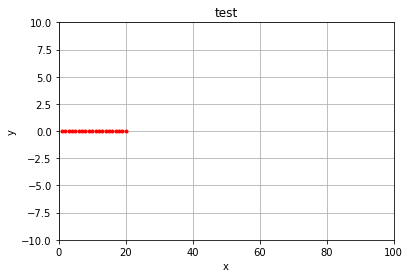

In [31]:
# -*- coding:utf8 -*-

from collections import defaultdict
import os
import re
import jieba
import codecs
import sys
import chardet
import matplotlib.pyplot as plt



# php install jieba





#使用jieba 函数  对 sentence 文本进行分词

def sent2word(sentence):


#调用jieba进行分词
    segList = jieba.cut(sentence)

#分词后的结果存为segResult 为list类型
    segResult = []
    for w in segList:
        segResult.append(w)

#调用 readLines 读取停用词
    stopwords = readLines(r'E:\dictionary\stop_words.txt')

#如果是停用词 就不保存到newSent
    newSent = []
    for word in segResult:
        if word+'\n' in stopwords:
            continue
        else:
            newSent.append(word)
#返回newSent
    return newSent


#直接对 sentence 进行分词  不使用停用词 并返回（主要是根据word需要这个操作）
def returnsegResult(sentence):

    segResult = []
    segList = jieba.cut(sentence)

    for w in segList:
        segResult.append(w)
    return segResult


#获取 filepath 目录下的所有文件目录并返回
def eachFile(filepath):
    pathDir =  os.listdir(filepath)
    child=[]
    for allDir in pathDir:
        child.append(os.path.join('%s/%s' % (filepath, allDir)))
    return child

#读取 filename路径 的每一行数据 并返回 转换为GBK
def readLines(filename):
    fopen = open(filename, 'r',encoding="UTF-8")
    #fopen1=fopen.encode("GBK")
    data=[]
    for x in fopen.readlines():
        if x.strip() != '':
                #str(x.strip())
                #data.append(str.encode("GBK"))
                data.append(unicode(x.strip(),"GBK"))
    fopen.close()
    return data



#读取 filename路径 的每一行数据 并返回
def readLines2(filename):
    fopen = open(filename, 'r',encoding='UTF-8')
    #fopen1=str(fopen)
    data=[]
    for x in fopen.readlines():
        if x.strip() != '':
                data.append(x.strip())

    fopen.close()
    return data

#主要为情感定位  见程序文件相关代码 这里是为了速度 提取了部分代码 本来应该在classifyWords 里边  貌似对速度影响不大
def words():
    #情感词
    senList = readLines2('E:\dictionary\BosonNLP_sentiment_score\BosonNLP_sentiment_score.txt')
    senDict = defaultdict()
    for s in senList:
        try:
            senDict[s.split(',')[0]] = s.split(',')[1]
        except:
            pass
    #否定词
    notList = readLines2(r'E:\dictionary\not.txt')
    #程度副词
    degreeList = readLines2(r'E:\dictionary\程度级别词语（中文）.txt')
    print(degreeList)
    degreeDict = defaultdict()
    for d in degreeList:
        print(d)
        try:
            degreeDict[d.split(' ')[0]] = d.split(' ')[1]
        except:
            pass

    return senDict,notList,degreeDict




# 见文本文档  根据情感定位  获得句子相关得分
def classifyWords(wordDict,senDict,notList,degreeDict):

    senWord = defaultdict()
    notWord = defaultdict()
    degreeWord = defaultdict()
    for word in wordDict.keys():
        if word in senDict.keys() and word not in notList and word not in degreeDict.keys():
            senWord[wordDict[word]] = senDict[word]
        elif word in notList and word not in degreeDict.keys():
            notWord[wordDict[word]] = -1
        elif word in degreeDict.keys():
            degreeWord[wordDict[word]] = degreeDict[word]
    return senWord, notWord, degreeWord


#计算句子得分  见程序文档
def scoreSent(senWord, notWord, degreeWord, segResult):
    W = 1
    score = 0
    # 存所有情感词的位置的列表
    senLoc = senWord.keys()
    notLoc = notWord.keys()
    degreeLoc = degreeWord.keys()
    senloc = -1
    # notloc = -1
    # degreeloc = -1
    # 遍历句中所有单词segResult，i为单词绝对位置
    for i in range(0, len(segResult)):
        # 如果该词为情感词
        if i in senLoc:
            # loc为情感词位置列表的序号
            senloc += 1
            # 直接添加该情感词分数
            score += W * float(senWord[i])
            # print "score = %f" % score
            if senloc < len(senLoc) - 1:
                # 判断该情感词与下一情感词之间是否有否定词或程度副词
                # j为绝对位置
                for j in range(senLoc[senloc], senLoc[senloc + 1]):
                    # 如果有否定词
                    if j in notLoc:
                        W *= -1
                    # 如果有程度副词
                    elif j in degreeLoc:
                        W *= float(degreeWord[j])
        # i定位至下一个情感词
        if senloc < len(senLoc) - 1:
            i = senLoc[senloc + 1]
    return score


#列表 转 字典
def listToDist(wordlist):
    data={}
    for x in range(0, len(wordlist)):
        data[wordlist[x]]=x
    return data

#绘图相关  自行百度下
def runplt():
    plt.figure()
    plt.title('test')
    plt.xlabel('x')
    plt.ylabel('y')
    #这里定义了  图的长度 比如 2000条数据 就要 写 0,2000  
    plt.axis([0,100,-10,10])
    plt.grid(True)
    return plt




#主题从这里开始 上边全是方法
score_var=[]


#获取 本地的情感词 否定词 程度副词
words_vaule=[]
words_vaule=words()
import jieba
import os
from jieba import analyse
# 引入TF-IDF关键词抽取接口
tfidf = analyse.extract_tags
rootdir0 = r'E:\python'
list0 = os.listdir(rootdir0) #列出文件夹下所有的目录与文件
#print(list0)
for j in range(0,len(list0)):
    data={}
    path = os.path.join(rootdir0,list0[j])
    if os.path.isdir(path):
        print(path)
        li = os.listdir(path) 
        for i in range(0,len(li)):
            path1 = os.path.join(path,li[i])
            if os.path.isfile(path1):
                fb=open(path1,'r')
                content=fb.read()
                fb.close()
        #words=jieba.lcut(content)
                keywords = tfidf(content)
                for word in keywords:
                    if len(word)>1:#去掉单个字符
                        if word in data:
                            data[word]+=1
                        else:
                            data[word]=1
        hist= list(data.items())#转成列表，便于排序
        hist1=str(hist)
        #print(hist1)
        print(content)
        datafen_dist=listToDist(hist)
        print(datafen_dist)
    #通过classifyWords函数 获取句子的 情感词 否定词 程度副词 相关分值
        data_1=classifyWords(datafen_dist,words_vaule[0],words_vaule[1],words_vaule[2])
    # 通过scoreSent 计算 最后句子得分
        data_2=scoreSent(data_1[0],data_1[1],data_1[2],returnsegResult(content))
    # 将得分保存在score_var 以列表的形式
        score_var.append(data_2)
    #打印句子得分
        print (data_2)

#获取 test/neg 下所有文件 路径
 #filepwd=eachFile("E:/neg"#​filepwd=eachFile("E:/neg")



#

#对所有句子得分进行倒序排列
score_var.sort(reverse=True)

#计算一个index 值 存 1~ 所有句子长度 以便于绘图
index=[]
for x in range(0,len(score_var)):
    index.append(x+1)

#初始化绘图
plt=runplt();
#带入参数
plt.plot(index,score_var,'r.')
#显示绘图
plt.show();

In [ ]:
import numpy as np
score_var=[]


#获取 本地的情感词 否定词 程度副词
words_vaule=[]
words_vaule=words()

#循环 读取 filepwd  （也就是test/neg目录下所有文件全部跑一下）
for x in filepwd:
    #读目录下文件的内容
    data=readLines(x)
    #对data内容进行分词
    datafen=sent2word(data[0])
    #列表转字典
    datafen_dist=listToDist(datafen)
    #通过classifyWords函数 获取句子的 情感词 否定词 程度副词 相关分值
    data_1=classifyWords(datafen_dist,words_vaule[0],words_vaule[1],words_vaule[2])
    # 通过scoreSent 计算 最后句子得分
    data_2=scoreSent(data_1[0],data_1[1],data_1[2],returnsegResult(data[0]))
    # 将得分保存在score_var 以列表的形式
    score_var.append(data_2)
    #打印句子得分
    print (data_2)